# Model deployment

Nuestros modelos deben ser, preferiblemente, utilizables para los demas...

Independientemente de nuestra separación de datos para la prueba de nuestros modelos, si estos no son probados en el mundo real, ¿qué son...?

<center><img heigth=700 width=700 src="img/model_deployment.png"></center>

Una buena practica para llevar a cabo este ultimo "dataset" es *MLOps*: https://es.wikipedia.org/wiki/MLOps.

Estos aspectos son los pre-producción de nuestro modelo o proyecto de software, es importante destacar esto ya que si bien la practica y experiencia son más importantes que la teoria muchas veces damos por hecho que este tema no tiene sentido cuando lo cierto es que lo tiene y mucho, que las cosas funcionen bien nos dará comida como programadores, no que nos guste como codeamos nuestro modelo o programa.

Previo a nuestra salida a producción debemos preguntarnos...:

 ***1. ¿Cual es el escenario ideal de funcionamiento de nuestro modelo?***
- Trabajar todo el tiempo
- Trabajar rapidamente

***2. ¿Donde va a andar nuestro modelo?***
- En la nube (cloud)
- Procesador (CPU, cuda)
- GPU

***3. ¿Cómo funcionará?***
- Online (tiempo real)
- Offline (batch)

# Modelos y la nube (Cloud)

Nuestros modelos son muy utiles para nosotros, sirve de mucho y claramente tienen un gran código detras que nos llevo horas de código, practica y paciencia... sin embargo estos mayormente son utilizados no en PCs locales sino en la nube, pongamos como ejemplo un auto de tesla:

<center><img src="img/cloud_vs_edge.png"></center>

Lo que es para nosotros "la nube" son en realidad miles de PCs conectadas de tal manera que nuestros modelos son infitamente mejores entrenados que en nuestra PC local.

Como extra el curso nos proporciona el siguiente recurso para correr nuestros modelos en la web: https://onnxruntime.ai/index.html

Los resultados podrán ser o no en tiempo real.

Los modelos correran localmente si la seguridad lo amerita y/o si la necesidad de computo no es muy grande.

Algunos recursos para realizar MLOps son los siguientes:

<center><img width=700 heigth=700 src="img/ml_ops.png"></center>

Trataremos de simular esto en este laboratorio.

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary

from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

c:\Users\marti\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Descargamos el set de datos

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi_20_percent')

In [3]:
# Creamos los directorios

train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

# Esperamos...

Que tenga un 95% de exactitud y que la velocidad sea de 30 FPS (No se que quiere decir con 30 FPS, no es un juego ni hay una interfaz gráfica pero bueno, se espera velocidad y eso es lo importante).

Los modelos que vimos fueron los siguientes:

- EffNetB2
- ViT-B/16

Previamente ademas de crear estos modelos creamos un *feature extractor* para cada uno, esto nos servirá ahora para evaluarlos también...

In [4]:
# Pesos y transforms:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

effnetb2_transforms = effnetb2_weights.transforms()

# Instanciamos un modelo con los pesos que ya creamos antes
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

for param in effnetb2.parameters():
    param.requires_grad = False

# effnetb2

In [5]:
effnetb2.classifier # head, debemos cambiar la salida a 3 clases (pizza, steak, sushi)

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [6]:
# Actualizamos el head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=3)
)

effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=3, bias=True)
)

In [7]:
# Simplifiquemos todo en una función...

def create_effnetb2_model(num_classes:int=3,
                         seed:int=42):
    
    """ Crea un extractor de atributos del modelo EfficientNetB2
    
    Args:
        num_classes (int, opcional): numero de clases a clasificar, el default es 3
        seed(int, opcional): semilla de aleatoriedad, el default es 42
    """
    # 1. Creamos el modelo con los pesos y transforms correspondientes
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 2. requieres_grad = False en las capas base
    for param in model.parameters():
        param.requires_grad = False

    # 3. Crear aleatoriedad y cambiar el head del modelo
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )

    return model, transforms

In [8]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,seed=42)

In [9]:
from torchinfo import summary

summary(effnetb2, 
         input_size=(1, 3, 224, 224),
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [10]:
# DataLoaders
from going_modular.going_modular import data_setup
train_data_loader_effnetb2, test_data_loader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                   test_dir=test_dir,
                                                                                                   transform=effnetb2_transforms,
                                                                                                   batch_size=32)

# len(train_data_loader_effnetb2), len(test_data_loader_effnetb2), class_names

In [11]:
# Llevemos los datos al modelo entonces...

from going_modular.going_modular import engine

# Función de perdida
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizador
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

# Función de entrenamiento de engine
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_data_loader_effnetb2,
                                test_dataloader=test_data_loader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device="cpu")

  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\marti\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 10%|█         | 1/10 [03:06<27:58, 186.49s/it]

Epoch: 1 | train_loss: 0.9877 | train_acc: 0.5729 | test_loss: 0.7434 | test_acc: 0.9284


 20%|██        | 2/10 [05:41<22:23, 167.99s/it]

Epoch: 2 | train_loss: 0.7031 | train_acc: 0.8854 | test_loss: 0.5845 | test_acc: 0.9409


 30%|███       | 3/10 [08:03<18:11, 155.93s/it]

Epoch: 3 | train_loss: 0.5907 | train_acc: 0.8187 | test_loss: 0.4750 | test_acc: 0.9347


 40%|████      | 4/10 [10:30<15:15, 152.63s/it]

Epoch: 4 | train_loss: 0.4885 | train_acc: 0.8729 | test_loss: 0.4018 | test_acc: 0.9409


 50%|█████     | 5/10 [12:36<11:54, 142.97s/it]

Epoch: 5 | train_loss: 0.4122 | train_acc: 0.9271 | test_loss: 0.3759 | test_acc: 0.9659


 60%|██████    | 6/10 [14:43<09:09, 137.41s/it]

Epoch: 6 | train_loss: 0.4277 | train_acc: 0.8875 | test_loss: 0.3498 | test_acc: 0.9659


 70%|███████   | 7/10 [16:39<06:31, 130.44s/it]

Epoch: 7 | train_loss: 0.3927 | train_acc: 0.8792 | test_loss: 0.3230 | test_acc: 0.9347


 80%|████████  | 8/10 [18:42<04:16, 128.07s/it]

Epoch: 8 | train_loss: 0.3267 | train_acc: 0.8896 | test_loss: 0.3115 | test_acc: 0.9437


 90%|█████████ | 9/10 [20:35<02:03, 123.48s/it]

Epoch: 9 | train_loss: 0.3139 | train_acc: 0.9083 | test_loss: 0.3006 | test_acc: 0.9563


100%|██████████| 10/10 [22:16<00:00, 133.66s/it]

Epoch: 10 | train_loss: 0.2874 | train_acc: 0.9396 | test_loss: 0.2657 | test_acc: 0.9597


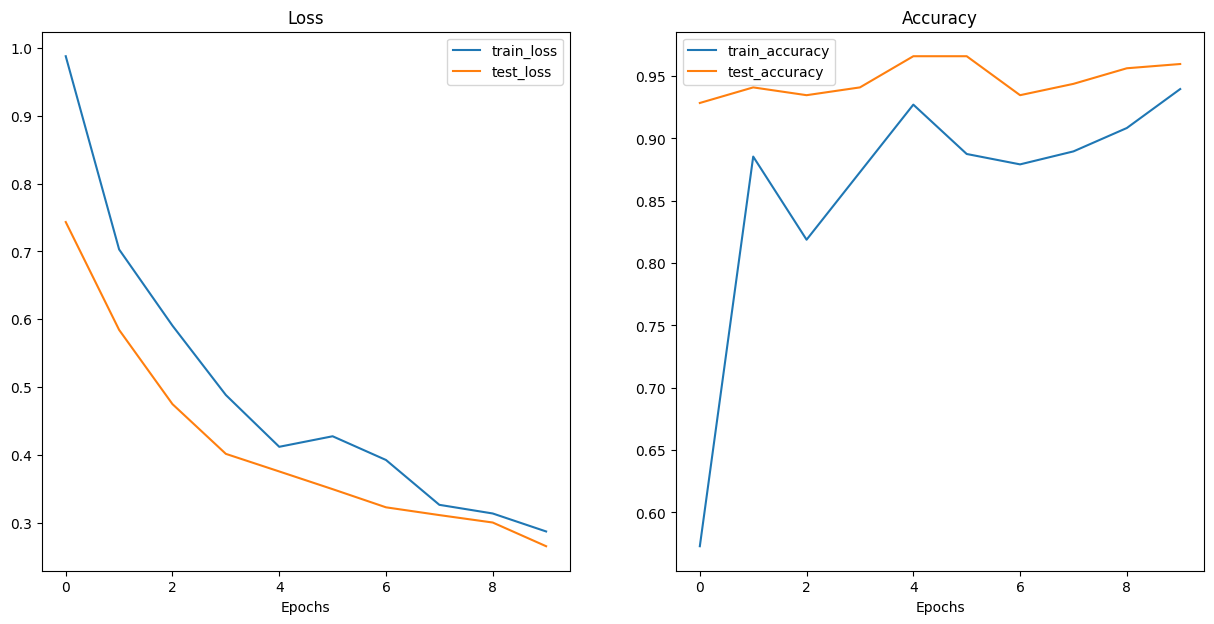

In [12]:
# Grafiquemos esto...
from helper_functions import plot_loss_curves

plot_loss_curves(results=effnetb2_results)

El modelo responde muy bien, no esta sobreentrenado, una buena idea será guardarlo.

Así sea bueno, es importante previo a sacarlo a producción ver cuanto pesa.

In [13]:
from going_modular.going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [14]:
from pathlib import Path

pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"Tamaño del pretrained effnetb2 feature extractor model: {round(pretrained_effnetb2_model_size, 2)} MB")

Tamaño del pretrained effnetb2 feature extractor model: 29.86 MB


In [15]:
# Diccionario con las estadisticas de nuestro EffNetB2

effnet2_total_params = sum(torch.numel(param) for param in effnetb2.parameters()) # Iteramos por compresión y sumamos...

effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnet2_total_params,
                  "model_size": pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.2656757295131683,
 'test_acc': 0.959659090909091,
 'number_of_parameters': 7705221,
 'model_size': 29.8577299118042}

# Hacemos lo mismo con ViT

In [16]:
vit = torchvision.models.vit_b_16()
vit.heads # Cambiar outputs

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [17]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    # Crear un modelo ViT_B_16 pre entrenado con pesos y transforms
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    for param in model.parameters():
        param.requires_grad = False
    
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768,
                                          out_features=num_classes))
    
    return model, transforms

In [18]:
vit, vit_transforms = create_vit_model()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [19]:
effnetb2_transforms # Son casi iguales

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [20]:
from torchinfo import summary

summary(vit, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

# DataLoadersr para ViT feature extractor

In [21]:
from going_modular.going_modular import data_setup

train_data_loader_vit, test_data_loader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                         test_dir=test_dir,
                                                                                         transform=vit_transforms,
                                                                                         batch_size=32)

# len(train_data_loader_vit), len(test_data_loader_vit), class_names

# Entrenamiento para ViT feature extractor

In [22]:
from going_modular.going_modular import engine

# Optimizador
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)

# Función de perdida
loss_fn = torch.nn.CrossEntropyLoss()

# Entrenamiento...
set_seeds()
vit_results = engine.train(model=vit, 
                           train_dataloader=train_data_loader_vit,
                           test_dataloader=test_data_loader_vit,
                           loss_fn=loss_fn,
                           optimizer=optimizer,
                           epochs=10,
                           device="cpu")

 10%|█         | 1/10 [03:49<34:21, 229.09s/it]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381


 20%|██        | 2/10 [08:51<36:18, 272.36s/it]

Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602


 30%|███       | 3/10 [14:18<34:40, 297.18s/it]

Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693


 40%|████      | 4/10 [19:05<29:18, 293.00s/it]

Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722


 50%|█████     | 5/10 [23:11<23:01, 276.24s/it]

Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784


 60%|██████    | 6/10 [27:26<17:55, 268.92s/it]

Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722


 70%|███████   | 7/10 [31:54<13:26, 268.70s/it]

Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784


 80%|████████  | 8/10 [36:35<09:05, 272.64s/it]

Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722


 90%|█████████ | 9/10 [41:12<04:33, 273.96s/it]

Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784


100%|██████████| 10/10 [46:32<00:00, 279.29s/it]

Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


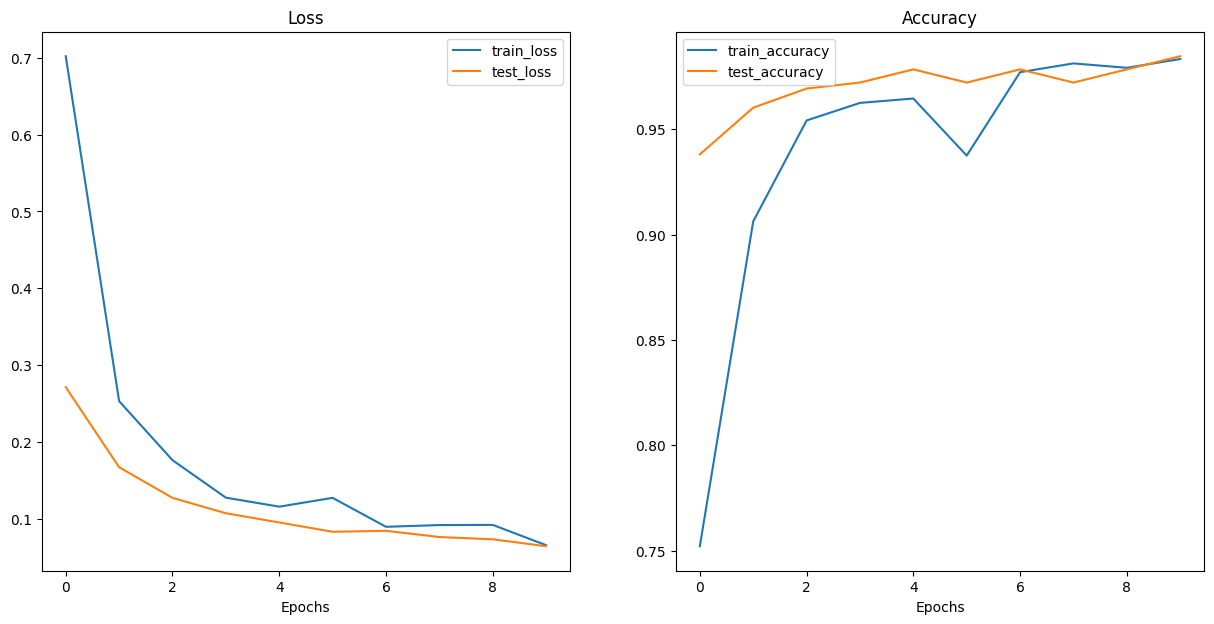

In [23]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results) # Se hizo desear pero funcino bien

In [24]:
# Guardemos el modelo...
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vir_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\09_pretrained_vir_feature_extractor_pizza_steak_sushi_20_percent.pth


In [25]:

from pathlib import Path
pretrained_vit_model_size = Path("models/09_pretrained_vir_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"Tamaño del modelo preentrenado ViT: {pretrained_vit_model_size} MB")

Tamaño del modelo preentrenado ViT: 327 MB


In [26]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

# Diccionario de las estadisticas de nuestro modelo ViT

vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size": pretrained_vit_model_size}


Ya podrémos crear predicciones con nuestros modelos, creemos entonces una lista con los directorios correspondientes...

In [27]:
from pathlib import Path

print(f"[INFO] Encontrando todos los .jpg del directorio: {test_dir}...")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

[INFO] Encontrando todos los .jpg del directorio: data\pizza_steak_sushi_20_percent\test...


# Función para generar predicciones

Ahora que ya tenemos una lista de rutas de imagenes podrémos crear una función *pred_and_store()*:

1. Creamos una función que toma una lista de rutas de imagenes, un modelo entrenado de PyTorch, una serie de Transforms, una lista de clases a predecir y el device (cuda o cpu, dado que hice por terco el curso en mi PC siempre será cpu).
2. Crear una lista vacia para almacenar un diccionario con predicciones. Buscamos una función que retorne una lista de diccinarios, uno por predicción.
3. Iterar por la ruta deseada. 
4. Crear un diccionario vacio por cada iteración en el loop para guardar los valores predictivos por muestra.
5. Obtener la ruta de la muestra y el nombre de la clase verdadera.
6. Inicializar un timer usando `timeit.default_timer()`.
7. Abrir la imagen usando `PIL.Image.open(path)`
8. Transformar la imagen (transform) para que pueda ser utilizada por nuestro modelo agregando una dimensión batch y enviar la imagen al device.
9. Preparar el modelo en `inference_mode()` y ponerlo en modo `eval()`.
10. Calcular la probabiblidad de la predicción son `torch.softmax()` y el label usando `torch.argmax()`.
11. Añadir la probabilidad de predicción y clase al diccionario creado en el paso 4.
12. Finalizar el timer creado en el paso 6. 
13. Ver si la predicción es valida. 
14. Añadir esta al diccinario.
15. Retornar la lista de diccinarios de predicción.

In [28]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Crear función

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cpu") -> List[Dict]:
    # 2. Lista vacia con predicciones
    pred_list = []

    # 3. Iteramos por los directorios
    for path in tqdm(paths):

        # 4. Diccionario vacio para guardar predicciones
        pred_dict = {}

        # 5. Muestra de la ruta y la clase verdadera
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Inicializamos timer
        start_time = timer()

        # 7. Abrimos la ruta de  la imagen
        img = Image.open(path)

        # 8. Transformamos la imagen, añadimos una dimensión batch
        transformed_image = transform(img).unsqueeze(0)

        #9. model.eval()
        model.eval()

        # 10. Con la probabilidad de la predicción y en inference_mode() trabajamos sobre los proximos pasos
        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label]

            # 11. Añadimos la probabilidad al diccinario
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. Terminamos el timer()
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time - start_time, 4)
        
        # 13. Ver si la predicción es valida
        pred_dict["correct"] = class_name == pred_class

        # 14. Añadimos el diccionario a a lista...
        pred_list.append(pred_dict)
    
    # Retornamos la lista...
    return pred_list

Ya podrémos probar nuestra función...

In [29]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")

100%|██████████| 150/150 [00:15<00:00,  9.51it/s]


In [30]:
# effnetb2_test_pred_dicts

In [31]:
# Llevaremos effnetb2_test_pred_dicts a un DataFrame, esto nos permitirá usar numpy para obtener datos relevantes de nuestro experimento...

import pandas as pd

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9926,pizza,0.6010,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.5349,pizza,0.1020,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9910,pizza,0.1170,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.7013,pizza,0.0970,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.7696,pizza,0.1023,True


In [32]:
effnetb2_test_pred_df.correct.value_counts() # correct -> campo del dataframe

correct
True     144
False      6
Name: count, dtype: int64

In [33]:
# Tiempo promedio por predicción

effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"Tiempo promedio por predicción effnetb2: {effnetb2_average_time_per_pred}")

effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

Tiempo promedio por predicción effnetb2: 0.104


{'test_loss': 0.2656757295131683,
 'test_acc': 0.959659090909091,
 'number_of_parameters': 7705221,
 'model_size': 29.8577299118042,
 'time_per_pred_cpu': np.float64(0.104)}

Hagamos lo mismo con la arquitectura ViT:

In [34]:
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

100%|██████████| 150/150 [01:05<00:00,  2.30it/s]


In [35]:
# vit_test_pred_dicts

In [36]:
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9987,pizza,0.5633,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9957,pizza,0.4840,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9987,pizza,0.5316,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9869,pizza,0.4273,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9698,pizza,0.4220,True


In [37]:
vit_test_pred_df.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [38]:
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"Tiempo promedio por predicción arquitectura ViT: {vit_average_time_per_pred}")

Tiempo promedio por predicción arquitectura ViT: 0.4327


In [39]:
vit_stats["time_per_pred_cpu"] = round(vit_test_pred_df.time_for_pred.mean(), 4)
vit_stats

{'test_loss': 0.06443445552140474,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size': 327,
 'time_per_pred_cpu': np.float64(0.4327)}

# Comparemos modelos...

Ya tenemos dos modelos entrenados con el mismo dataset y hardware, ahora comparemos cual es mejor...

In [40]:
# Llevemos nuestros resultados a un DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Añadimos una columna indicadora de nombres

df["model"] = ["EffnetB2", "ViT"]

df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size,time_per_pred_cpu,model
0,0.265676,95.97,7705221,29.85773,0.1040,EffnetB2
1,0.064434,98.47,85800963,327.00000,0.4327,ViT


Teniendo en cuenta que función de perdida es menor y que exactitud de mayor podrémos saber cual es el menor.
En este caso y dado mi hardware podemos ver como la exactitud de ambos modelos son cercanas, pero el ViT tiene menos perdida por gran cantidad, por lo que en mi PC anduvo mejor el ViT... 
El numero de parametros del EffNet sin embargo es menor por muchísima cantidad.

In [41]:
# Comparemos los modelos según sus caracteristicas...
pd.DataFrame(data=df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffnetB2"],
             columns=["ViT a EffnetB2 radios"]).T

,test_loss,test_acc,number_of_parameters,model_size,time_per_pred_cpu
ViT a EffnetB2 radios,0.24253,1.02605,11.135432,10.951938,4.160577


# Grafiquemos la velocidad y el rendimiento en un *scatterplot*.

Para esto realizaremos lo siguiente:
1. Crear un scatterplot con la comparación del DataFrame EffNetB2 y ViT.
2. Añadir titulos y labels correspondientes.
3. Anotar las muestras correspondientes en el gráfico.
4. Crear una *legend* (leyenda) para ver el tamaño del modelo.

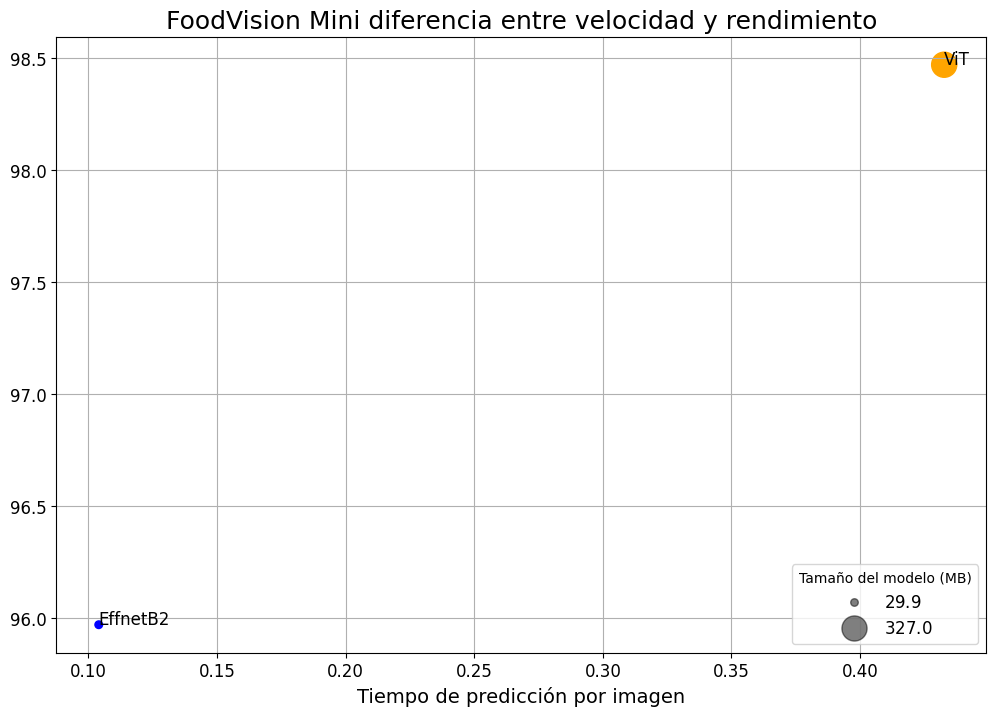

In [42]:
import matplotlib.pyplot as plt

# 1. Crear el grafico
fix, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size")

# 2. Añadir los titulos y labels
ax.set_title("FoodVision Mini diferencia entre velocidad y rendimiento", fontsize=18)
ax.set_xlabel("Tiempo de predicción por imagen", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid("on")

# 3. Anotemos las muestras utilizadas...
for index, row in df.iterrows():
    ax.annotate(text=row["model"],
                xy=(row["time_per_pred_cpu"], row["test_acc"]),
                size=12)
# 4. Leyenda
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Tamaño del modelo (MB)",
                              fontsize=12)

# Función `predict()` para ir de:
Imagenes de comida -> ML Model (ViT o EffNetB2) -> Salidas

In [43]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    # Inicializamos timer
    start_time = timer()

    # Creamos los transforms
    img = effnetb2_transforms(img).unsqueeze(0)

    # Ponemos el modelo en eval mode
    effnetb2.eval()
    with torch.inference_mode():
        # Imagen transformada através del modelo
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Diccionario con labels de predicción y probabilidad por compresión
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Tiempo de predicción
    pred_time = round(timer() - start_time, 5)

    # Retornamos diccionario y tiempo de predicción
    return pred_labels_and_probs, pred_time

Ahora creemos una lista con las rutas de nuestras imagenes de prueba...

In [44]:
import random
from PIL import Image

# Lista de directorios de prueba
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Lista aleatorea de directorios
random_image_path = random.sample(test_data_paths, k=1)[0]

# Abrimos la imagen 
image = Image.open(random_image_path)
print(f"Abriendo {random_image_path}...")

# Predicción
pred_dict, pred_time = predict(img=image)
pred_time, pred_dict

Abriendo data\pizza_steak_sushi_20_percent\test\pizza\1687143.jpg...


(0.27722,
 {'pizza': 0.9344996213912964,
  'steak': 0.04998898506164551,
  'sushi': 0.01551135629415512})

In [45]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data\\pizza_steak_sushi_20_percent\\test\\steak\\108310.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\steak\\2069289.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\pizza\\724290.jpg']]

# Gradio

Gradio es una biblioteca de Python que facilita la creación de interfaces de usuario interactivas para modelos de aprendizaje automático (machine learning).

Permite a los desarrolladores construir aplicaciones web de manera rápida y sencilla, donde los usuarios pueden interactuar con modelos, cargar datos y ver resultados en tiempo real.

In [46]:
import gradio as gr

# Crear titulo, descripción y articulo
title = "FoodVision Mini"
description = "Modelo EfficientNetB2 Feature Extractor"
article = "Creado por Martin Zwarycz durante el curso de PyTorch de ZeroToMastery"

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predicciones"),
                             gr.Number(label="Tiempo en predecir(s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch(debug=False,
            share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://cf5e39a9615c3c328b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Almacenemos en `demos` los archivos de nuestro FoodVisionz app creado en gradio.

In [47]:
import shutil 
from pathlib import Path

foodvision_mini_demo_path = Path("demos/foodvision_mini/")

if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True,
                                    exist_ok=True)
else: 
        foodvision_mini_demo_path.mkdir(parents=True,
                                        exist_ok=True)

In [48]:
# Insertemos ejemplos...
import shutil 
from pathlib import Path

# 1. Crear directorio de ejemplos
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

# 2. Poner 3 ejemplos al azar hardcodeados
foodvision_mini_examples = [Path("data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg"),
                            Path("data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg"),
                            Path("data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg")]

# 3. Copiar las imagenes de prueba a los directorios de ejemplo
for example in foodvision_mini_examples:
    destination = foodvision_mini_demo_path / example.name
    print(f"Copiando {example} a {destination}")
    shutil.copy2(src=example, dst=destination)

Copiando data\pizza_steak_sushi_20_percent\test\sushi\592799.jpg a demos\foodvision_mini\592799.jpg
Copiando data\pizza_steak_sushi_20_percent\test\steak\3622237.jpg a demos\foodvision_mini\3622237.jpg
Copiando data\pizza_steak_sushi_20_percent\test\pizza\2582289.jpg a demos\foodvision_mini\2582289.jpg


In [49]:
import os
# Confirmamos por compresión en una lista de lista de directorios si todo se realizo correctamente:

example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_demo_path)]
example_list

[['examples/2582289.jpg'], ['examples/3622237.jpg'], ['examples/592799.jpg']]

In [50]:
# Movamos el modelo entrenado EffNetB2 a nuestro directorio

import shutil 

# Creamos nueva ruta
effnetb2_foodvision_mini_model_path = "models/09_pretrained_vir_feature_extractor_pizza_steak_sushi_20_percent.pth"
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# effnetb2_foodvision_mini_model_path.split("/")[1]
# effnetb2_foodvision_mini_model_destination

# Movamos el archivo con un Try catch
try:
    print(f"Intentando mover {effnetb2_foodvision_mini_model_path} a {effnetb2_foodvision_mini_model_destination}...")
    # Movamos....
    shutil.move(src=effnetb2_foodvision_mini_model_path,
                dst=effnetb2_foodvision_mini_model_destination)
    
    print("Modelo movido")
except:
    print(f"No se encuentro el modelo en {effnetb2_foodvision_mini_model_path}, quizas ya fue movido...")
    print(f"El modelo ya existe en {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

Intentando mover models/09_pretrained_vir_feature_extractor_pizza_steak_sushi_20_percent.pth a demos\foodvision_mini\09_pretrained_vir_feature_extractor_pizza_steak_sushi_20_percent.pth...
Modelo movido


Llevemos el modelo EffNetB2 a un script de Python, lo llamaremos `model.py`.

In [51]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=3,
                         seed:int=42):
    """Crea un modelo EfficientNetB2 feature extractor and transforms
    
    Args:
        num_classes (int, optional): numero de clases a identificar.
        Default: 3
    
    Retorna:
          model (torch.nn.Module): EffNetB feature extractor model.
          transforms (torchvision.transforms): EffNet image transforms"""

    # Crear pesos ya entrenados, transforms y el modelo en cuestión
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.tranforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Congelamos las capas base
      for param in model.parameters():
        param.requires_grad = False

    # Cambiamos el classifier head y la semilla de aleatoriedad
    torch.manual_seed(seed)
     model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
        )

    return model, transforms

Writing demos/foodvision_mini/model.py


Llevmos también el modelo de Gradio a un script de Python `app.py`, para esto haremos lo siguiente:
1. Importar gradio
2. Preparar el modelo
3. Crear la función `predict()`
4. Crear la interfaz gradio

In [52]:
%%writefile demos/foodvision_mini/app.py

# 1. Importo grado y librerias a utilizar
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

class_names = ["pizza", "steak", "sushi"]

# 2. Preparamos el modelo:
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3
)

# Guardamos pesos
effnetb2.load_state_dict(
    torch.loader(
        f="09_pretrained_vir_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location="cpu"
    )
)

# 3. Creamos la función predict
def predict(img) -> Tuple[Dict, float]:
    # Inicializamos timer
    start_time = timer()

    # Creamos los transforms
    img = effnetb2_transforms(img).unsqueeze(0)

    # Ponemos el modelo en eval mode
    effnetb2.eval()
    with torch.inference_mode():
        # Imagen transformada através del modelo
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Diccionario con labels de predicción y probabilidad por compresión
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Tiempo de predicción
    pred_time = round(timer() - start_time, 5)

    # Retornamos diccionario y tiempo de predicción
    return pred_labels_and_probs, pred_time

# Interfaz Gradio

title = "FoodVision Mini"
description = "EfficientNetB2 feature extractor"
article = "Creado por Martín Zwarycz durante la realización del bootcamp de PyTorch."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


Debemos crear (no entiendo si obligatoriamente de momento) un archivo llamado `requirements.txt`

In [53]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_mini/requirements.txt


# Extra: mejoremos nuestro modelo...

Nuestros modelos fueron entrenados con 3 posibles clases... ¿qué tal si ahora sumamos más...? ¿qué tal si tenemos 101 clases posibles...?
<center><img src="img/food_vision_big.png"></center>

In [55]:
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

from torchinfo import summary

summary(effnetb2_food101, 
         input_size=(1, 3, 224, 224),
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [57]:
# Transforms

food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms,
])

# food101_train_transforms, effnetb2_transforms

In [58]:
# Importamos y configuramos DataSet

from torchvision import datasets
from pathlib import Path

data_dir = Path("data")

# Data de entrenamiento: (750 imagenes)
train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=food101_train_transforms,
                              download=True)

# Data de testeo: (250 imagenes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms,
                             download=True)

100%|██████████| 5.00G/5.00G [11:20<00:00, 7.35MB/s]   


In [60]:
food101_class_names = train_data.classes

# food101_class_names

Separemos ahora si mediante una función el dataset, si mal no estoy esto se puede hacer un sticklearn también...

In [ ]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    lenth_1 = int(len(dataset) * split_size)
    lenth_2 = len(dataset) - lenth_1

    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[lenth_1, lenth_2],
                                                                   generator=torch.manual_seed(seed))
    return random_split_1, random_split_2

In [64]:
# separación del 20% de entrnamiento Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# separación de 20% de prueba Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

# len(train_data_food101_20_percent), len(test_data_food101_20_percent)

Creemos los DataLoaders...:

In [66]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 

# DataLoader Entrenamiento
train_data_loader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)

# DataLoader Prueba o Test
test_data_loader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False,
                                                                  num_workers=NUM_WORKERS)

#  Ya podrémos entrenar nuestro modelo con el dataset FoodVision completo con 101 clases...

Para eso realizaremos:
1. 5 épocas
2. Un optimizador `Adam`.
3. Una función de perdida `CrossEntropyLoss` con `Smoothing` para evitar el sobreentrenamiento, es una tecnica de regularización.
4. Crearemos el modelo.

In [ ]:
from going_modular.going_modular import engine

# 1.Epocas

EPOCHS = 5

# 2. Optimizador
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)
# 3. Función de perdida
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# 4. Creamos el modelo 
set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_data_loader_food101_20_percent,
                                        test_dataloader=test_data_loader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=EPOCHS,
                                        device="cpu")

 20%|██        | 1/5 [48:20<3:13:20, 2900.01s/it]

Epoch: 1 | train_loss: 3.6438 | train_acc: 0.2758 | test_loss: 2.7908 | test_acc: 0.4842


In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_results)

# Guardemos el modelo

No perdamos este modelo entrenado!

In [ ]:
from going_modular.going_modular import utils

effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

utils.save_model(model=effnetb2_food101,
                 target_dir="models/",
                 model_name=effnetb2_food101_model_path)

In [ ]:
# Creamos entonces una instancia de EffNetB2 con Food101
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Cargamos el modelo...
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

Con gran parte de los archivos previos y *huggingface* podrémos subir nuestro modelo y usarlo en la web...